In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset
import matplotlib.ticker as ticker
from scipy.stats import chi2_contingency

In [2]:
# Data explanation

# FONTOS: Minden event-re tamadaskent hivatkozunk (ettol fuggetlenul persze a nagy reszuk nem volt tamdas, csak magas forgalom)

# Tomoren: A components tabla elemei az egyes tamadasok soran keszult 'snapshot'-ok a halozat allapotarol (egy tamadashoz akar tobb ilyen 'snapshot' is lehet)
# Az events tabla elemei pedig egy-egy tamadast irnak le, igazabol az events tabla sorai az azonos Attack ID-val rendelkezo komponensek aggregacioja (atlaga, osszege, stb.)

##### Components #####
# Egy adott idopillanatban tukrozi halozat allapotat, egy snaphot
# Az Attack ID azonositja, hogy melyik tamadasnak a resze az adot idopillanatbeli allapot, ebben a tablaban az Attack ID nem egyedi
Components = {
    "Attack ID": "Egy adott tamadashoz (ami egy event) tartozo azonosito. Egy sora a tablanak azt mondja meg, hogy az adott tamadasnak az adott idopillanatban milyen allapotaban van a halozat.",
    "Detect count": "Azt mondja meg, hogy a bejegyzes az adott Attack ID-ju tamadasnak hanyadik detektalasa. pl lehet, hogy egy tamadast csak egyszer detektalunk, de lehet, hogy a tamadas soran tobbszor is valami gyanusat erzekelt a detektor es ezeket mindet feljegyezte",
    "Card": "A detektor melyik kartyaja vegezte az adatgyujtest",
    "Victim IP": "A tamadas aldozatanak IP cime (anonimizalva)",
    "Port number": "A tamadas cel portja",
    "Attack code": "A tamadas jelleget irja le, amibol gyanus volt a detektornak, hogy tamadas tortenik. pl.: High volume / Suspicious traffic, CLDAP. Akar tobb is lehet egy sorban.",
    "Significant flag": "A DDoS detektor belso flagje, SZAMUNKRA NEM FONTOS",
    "Packet speed": "csomagráta (hálózaton áthaladó csomagok száma másodpercenként) [pps]",
    "Data speed": "adatrata (hálózaton áthaladó adatmennyiség másodpercenként) [bps]",
    "Avg packet len": "átlagos csomaghossz [byte]",
    "Source IP count": "Egyedi IP cimek szama, akik az adott idopillanatban tamadnak",
    "Time": "Timestamp, hogy mikor keszult a snapshot"
}


##### Events #####
# egy-egy tamadast reprezental
# Azonos Attack ID-val rendelkezo komponensek aggregacioja, a teljes tamadast reprezentalja, az Attack ID egyedi
Events = {
    "Attack ID": "ugyanaz, mint a Components tablaban, de itt egyedi",
    "Card": "ugyanaz, mint a Components tablaban",
    "Victim IP": "ugyanaz, mint a Components tablaban",
    "Port number": "ugyanaz, mint a Components tablaban",
    "Attack code": "uyanaz, mint a Components tablaban, az adott Attack ID-hoz tartozo osszes komponens Attack code-janak az osszessege",
    "Detect count": "Hanyszor volt az adott Attack ID-val rendelkezo tamadas detektalva.",
    "Singificant flag": "ugyanugy nem fontos",
    "Packet speed": "Atlagos csomagráta a tamadas soran",
    "Data speed": "Atlagos adatrata a tamadas soran",
    "Avg packet len": "Atlagos csomaghossz a tamadas soran",
    "Avg Source IP count": "Atlagososan hany IP-rol tortent a tamadas",
    "Start time": "Timestamp, mikor kezdodott a tamadas",
    "End time": "Timestamp, mikor vegezodott a tamadas",
    "Whitelist flag": "Detektor belso flagje, SZAMUNKRA NEM FONTOS",
    "Type": "Az esemeny kategoriaja, aminek a detektor felcimkezte, ezt kell majd nekunk prediktalni neuralis haloval. Itt ez a 'ground truth' adat. Lehetseges ertekei: DDoS attack, Suspicious traffic vagy Normal traffic"
}

In [ ]:
component_columns = [
    "Attack ID", "Detect count", "Card", "Victim IP", "Port number",
    "Attack code", "Significant flag", "Packet speed", "Data speed", "Avg packet len",
    "Source IP count", "Time"
]

event_columns = [
    "Attack ID", "Card", "Victim IP", "Port number", "Attack code", 
    "Detect count", "Significant flag", "Packet speed", "Data speed", 
    "Avg packet len", "Avg source IP count", "Start time", "End time", 
    "Whitelist flag", "Type"
]

class DataPartition(Dataset):
    def __init__(self, data_partition):
        super().__init__()
        self.component_columns = component_columns
        self.event_columns = event_columns
        self.data_partition = data_partition
        
        self.components, self.events = self.load_data(data_partition)
        
        self.filter_invalid_rows_from_events()
        self.add_duration_to_events()
        
        self.components_categorical, self.components_numeric, self.events_categorical, self.events_numeric = self.transform_data_for_corr_analysis()
        
        self.components_cleaned, self.events_cleaned = self.clean_data()
        
    def load_data(self, data_partition):
        if data_partition == "A" or data_partition == "B":
            data_path = f'/home/appuser/data/train/SCLDDoS2024_Set{data_partition}'
        elif data_partition == "C":
            data_path = '/home/appuser/data/test/SCLDDoS2024_SetC'
        elif data_partition == "D":
            data_path = '/home/appuser/data/gen/SCLDDoS2024_SetD'
        else:
            raise ValueError("Invalid data partition, the valid options are: A, B, C, D")
        
        components = pd.read_csv(f'{data_path}_components.csv')
        events = pd.read_csv(f'{data_path}_events.csv')
        
        components.columns = self.component_columns
        events.columns = self.event_columns

        return components, events

    # remove the rows that has the End Time set to 0 as we don't know what that means
    def filter_invalid_rows_from_events(self):
        self.events = self.events[self.events['End time'].astype(str) != '0']

    # add a new column to the events dataframe that contains the duration of the event
    def add_duration_to_events(self):
        self.events['Start time'] = pd.to_datetime(self.events['Start time'])
        self.events['End time'] = pd.to_datetime(self.events['End time'])
        self.events['Duration'] = (self.events['End time'] - self.events['Start time']).dt.total_seconds().astype(int)
    
    def frequency_encode(self, df, columns):
        for column in columns:
            freq = df[column].value_counts()
            df[column + '_freq'] = df[column].map(freq)
        return df
    
    def one_hot_encode(self, df, columns):
        df = pd.concat([df, pd.get_dummies(df[columns])], axis=1)
        df.drop(columns=columns, inplace=True)
        return df

    def one_hot_encode_AC(self, df):        
        attack_codes = df['Attack code'].str.get_dummies(sep=', ').add_prefix('AC - ')
        df = pd.concat([df, attack_codes], axis=1)
        df.drop(columns=['Attack code'], inplace=True)
        return df
    
    def extract_time_components(self, df, column):
        df[column] = pd.to_datetime(df[column])
        df[column + '_year'] = df[column].dt.year
        df[column + '_month'] = df[column].dt.month
        df[column + '_day'] = df[column].dt.day
        df[column + '_hour'] = df[column].dt.hour
        df[column + '_minute'] = df[column].dt.minute
        df[column + '_second'] = df[column].dt.second
        return df
    
    def add_cyclic_features(self, df, column, period):
        df[column + '_sin'] = np.sin(2 * np.pi * df[column] / period)
        df[column + '_cos'] = np.cos(2 * np.pi * df[column] / period)
        return df
    
    def normalize_column(self, df, column):
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
        return df
    
    def transform_data_for_corr_analysis(self):   
        components_num_features = [
        'Detect count', 'Packet speed', 'Data speed', 'Avg packet len', 'Source IP count'
        ]

        components_cat_features = [
            'Port number', 'Attack code'
        ]

        events_num_features = [
            'Detect count', 'Packet speed', 'Data speed', 'Avg packet len', 'Avg source IP count', 'Duration'
        ]

        events_cat_features = [
            'Port number', 'Attack code', 'Type'
        ]
        
        # Create copies of the components and events dataframes
        components_num = self.components[components_num_features].copy()
        components_cat = self.components[components_cat_features].copy()
        events_num = self.events[events_num_features].copy()
        events_cat = self.events[events_cat_features].copy()
        
        # Drop port number
        components_cat_features.remove('Port number')
        events_cat_features.remove('Port number')
        
        components_cat.drop(columns=['Port number'], inplace=True)
        events_cat.drop(columns=['Port number'], inplace=True)
        
        # OPTIONAL: Categorize ports into 3 categories: 0-1023, 1024-49151, 49152-65535
        # components_cat['Port number'] = pd.cut(components_cat['Port number'], bins=[0, 1023, 49151, 65535], labels=['0-1023', '1024-49151', '49152-65535'])
        # events_cat['Port number'] = pd.cut(events_cat['Port number'], bins=[0, 1023, 49151, 65535], labels=['0-1023', '1024-49151', '49152-65535'])
        
        # OPTIONAL: One-hot encode attack code
        # components_cat = self.one_hot_encode_AC(components_cat)
        # events_cat = self.one_hot_encode_AC(events_cat)
        
        # OPTIONAL: One-hot encode type
        # events_cat = self.one_hot_encode(events_cat, ['Type'])
        # components_cat = self.one_hot_encode(components_cat, ['Type'])
        
        # Explode the 'Attack code' column
        components_cat = components_cat.assign(**{'Attack code': components_cat['Attack code'].str.split(', ')}).explode('Attack code')
        events_cat = events_cat.assign(**{'Attack code': events_cat['Attack code'].str.split(', ')}).explode('Attack code') 
        
        # Normalize  numerical features
        for feature in components_num_features:
            components_num = self.normalize_column(components_num, feature)
        
        for feature in events_num_features:
            events_num = self.normalize_column(events_num, feature)
        
        return components_cat, components_num, events_cat, events_num
    
    def clean_data(self):
        # Make a deep copy of the original dataframes
        components_cleaned = self.components.copy(deep=True)
        events_cleaned = self.events.copy(deep=True)
        
        # Drop columns that are not needed for the model
        components_cleaned.drop(columns=['Card', 'Significant flag'], inplace=True)
        events_cleaned.drop(columns=['Card', 'Significant flag', 'Start time', 'End time', 'Whitelist flag'], inplace=True)
        
        # Clean IP columns (remove 'IP_' prefix)
        components_cleaned['Victim IP'] = components_cleaned['Victim IP'].str.replace('IP_', '')
        events_cleaned['Victim IP'] = events_cleaned['Victim IP'].str.replace('IP_', '')
        
        # Frequency encode categorical features
        components_cleaned = self.frequency_encode(components_cleaned, ['Victim IP', 'Port number'])
        
        # One-hot encode
        events_cleaned = self.one_hot_encode(events_cleaned, ['Type'])
        
        # One-hot encode attack code in events
        events_cleaned = self.one_hot_encode_AC(events_cleaned)
        components_cleaned = self.one_hot_encode_AC(components_cleaned)
        
        # Extract date and time components
        components_cleaned = self.extract_time_components(components_cleaned, 'Time')
        components_cleaned.drop(columns=['Time'], inplace=True)
        
        # Add cyclic features for hours of the day and drop the original columns
        components_cleaned = self.add_cyclic_features(components_cleaned, 'Time_month', 12)
        components_cleaned = self.add_cyclic_features(components_cleaned, 'Time_day', 31)
        components_cleaned = self.add_cyclic_features(components_cleaned, 'Time_hour', 24)
        components_cleaned = self.add_cyclic_features(components_cleaned, 'Time_minute', 60)
        components_cleaned = self.add_cyclic_features(components_cleaned, 'Time_second', 60)
        
        # Drop the original columns
        components_cleaned.drop(columns=['Time_year', 'Time_month', 'Time_day', 'Time_hour', 'Time_minute', 'Time_second'], inplace=True)
        
        if 'Start time' in events_cleaned.columns:
            events_cleaned = self.extract_time_components(events_cleaned, 'Start time')
            events_cleaned.drop(columns=['Start time'], inplace=True)
            
            events_cleaned = self.add_cyclic_features(events_cleaned, 'Start time_month', 12)
            events_cleaned = self.add_cyclic_features(events_cleaned, 'Start time_day', 31)
            events_cleaned = self.add_cyclic_features(events_cleaned, 'Start time_hour', 24)
            events_cleaned = self.add_cyclic_features(events_cleaned, 'Start time_minute', 60)
            events_cleaned = self.add_cyclic_features(events_cleaned, 'Start time_second', 60)
            
            events_cleaned.drop(columns=['Start time_year', 'Start time_month', 'Start time_day', 'Start time_hour', 'Start time_minute', 'Start time_second'], inplace=True)
        
        # Normalize numerical features
        components_num_features = ['Packet speed', 'Data speed', 'Avg packet len', 'Source IP count']
        events_num_features = ['Packet speed', 'Data speed', 'Avg packet len', 'Avg source IP count', 'Duration']
        
        for feature in components_num_features:
            components_cleaned = self.normalize_column(components_cleaned, feature)
        
        for feature in events_num_features:
            events_cleaned = self.normalize_column(events_cleaned, feature)
        
        # Convert all to float32
        components_cleaned = components_cleaned.astype('float32')
        events_cleaned = events_cleaned.astype('float32')
        
        return components_cleaned, events_cleaned
        
    def get_hist_bins_by_field(self, field):
        if field == "Duration":
            return np.arange(0, 305, 5), 10000
        elif field == 'Detect count':
            return np.arange(0, 51, 1), 50000
        else:
            raise ValueError("You provided an invalid field option")

    # How much of the datatset is DDos attack, normal traffic and suspicious traffic
    def create_dist_pie_chart_for_events(self, save=False):
        event_types = self.events['Type'].value_counts()
        percentages = event_types / event_types.sum() * 100  # Calculate percentages
        labels = [f"{label} ({percent:.1f}%)" for label, percent in zip(event_types.index, percentages)]  # Add percentages to labels
        
        event_types.plot.pie(labels=labels, autopct='', startangle=0, fontsize=12)  # Remove autopct
        plt.ylabel('')
        plt.title(f'Event type distribution for data partition {self.data_partition}', fontsize=16)
        if save:
            plt.savefig(f'plots/event_distribution_{self.data_partition}.png',bbox_inches='tight')
        plt.show()
        
    # Create a histogram based on the 'field' column
    def create_histogram_for_events(self, field, save=False):
        data = self.events.copy(deep=True)
        plt.figure(figsize=(27, 9))
        bins, ymax = self.get_hist_bins_by_field(field)

        ax = sns.histplot(
            data=data, 
            x=field,
            hue='Type',  
            bins=bins, 
            multiple="stack",  
            alpha=0.8,
            hue_order=["DDoS attack", "Suspicious traffic", "Normal traffic"],
            palette={
                "DDoS attack": "#28a745",
                "Suspicious traffic": "#dc3545",
                "Normal traffic": "#007bff"
            },
            legend=True,
            edgecolor='none',
            element='bars',
            shrink=0.9,
        )

        plt.gca().set_facecolor('lavender')
        plt.title(f'Event {field} histogram for data partition {self.data_partition}', fontsize=20)
        plt.xlabel(f'{field}', fontsize=18)
        plt.ylabel('Number of Occurrences', fontsize=18)
        plt.ylim(0, ymax)
        xmax = max(bins)
        plt.xlim(0, xmax)

        # Format y-axis labels to show 'k' for thousands
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}k'))

        # Increase font size for axis labels and ticks
        plt.tick_params(axis='both', labelsize=14)
        
        # Increase font size for legend
        plt.setp(ax.get_legend().get_texts(), fontsize=16)
        legend_title = ax.get_legend().get_title()
        if legend_title is not None:
            legend_title.set_fontsize(16)
        
        # Draw horizontal lines at the y-ticks (zorder = -1 puts it behind the columns)
        for y in ax.get_yticks():
            ax.axhline(y=y, color='white', linestyle='-', linewidth=2, alpha=0.5, zorder=-1) 
        
        if save:
            plt.savefig(f'plots/event_{field}_histogram_{self.data_partition}.png', bbox_inches='tight')
        plt.show()
        
    # Create a binwise normalised histogram based on the 'field' column
    def create_normalized_histogram_for_events(self, field, save=False):
        data = self.events.copy(deep=True)
        bins, _ = self.get_hist_bins_by_field(field)

        # Assign each data point to a bin
        data['bin'] = pd.cut(data[field], bins=bins, include_lowest=True)
    
        # Compute counts per bin per type
        counts = data.groupby(['bin', 'Type']).size().unstack(fill_value=0)

        # Normalize each bin so columns sum to 1
        normalized_counts = counts.div(counts.sum(axis=1), axis=0).fillna(0)        

        # Define categories
        categories = ["DDoS attack", "Suspicious traffic", "Normal traffic"]
        colors = ["#28a745", "#dc3545", "#007bff"]

        # Initialize the plot
        fig, ax = plt.subplots(figsize=(27, 9))
        
        ax.set_xticks(bins)  # Adjust step size as needed

        bottom = np.zeros(len(normalized_counts)) 
        for cat, color in zip(categories, colors):
            sns.barplot(
                x=bins[1:], 
                y=normalized_counts[cat], 
                color=color, 
                label=cat,
                edgecolor="none",
                bottom=bottom,
                alpha = 0.8,
            )
            bottom += normalized_counts[cat]  # Update bottom for stacking

        # Set background color
        ax.set_facecolor('lavender')

        # Set title, labels, and limits
        ax.set_title(f'Event {field} normalized histogram for data partition {self.data_partition}', fontsize=20)
        ax.set_xlabel(f'{field}', fontsize=18)
        ax.set_ylabel('Binwise relative proportion', fontsize=18)
        
        # Explicitly set x-limits and x-ticks
        plt.ylim(0, 1.1)
        
        ax.tick_params(axis='both', labelsize=14)
        
        # Increase font size for legend
        plt.setp(ax.get_legend().get_texts(), fontsize=16)
        legend_title = ax.get_legend().get_title()
        if legend_title is not None:
            legend_title.set_fontsize(16)

        # Draw horizontal lines at the y-ticks (zorder = -1 puts it behind the bars)
        for y in ax.get_yticks():
            ax.axhline(y=y, color='white', linestyle='-', linewidth=2, alpha=0.5, zorder=-1)

        # Save the figure if needed
        if save:
            plt.savefig(f'plots/event_{field}_normalized_histogram_{self.data_partition}.png', bbox_inches='tight')

        plt.show()
        
    # Calculte the spearman correlation between each pair of columns in the components and events tables (separately)
    def create_heatmap_spearman(self, table, save=False):
        if table == "components":
            self.plot_and_show_heatmap(self.components_numeric.corr(method="spearman"), "Spearman Correlation - Components", "heatmap_spearman_components.png", save)
        elif table == "events":
            self.plot_and_show_heatmap(self.events_numeric.corr(method="spearman"), "Spearman Correlation - Events", "heatmap_spearman_events.png", save)
        else:
            raise ValueError(f"Invalid table name: {table}. Choose 'components' or 'events'.")
        
    # Calculte the pearson correlation
    def create_heatmap_pearson(self, table, save=False):
        if(table == "components"):
            self.plot_and_show_heatmap(self.components_numeric.corr(method="pearson"), "Pearson Correlation - Components", "heatmap_pearson_components.png", save)
        elif(table == "events"):
            self.plot_and_show_heatmap(self.events_numeric.corr(method="pearson"), "Pearson Correlation - Events", "heatmap_pearson_events.png", save)
        else:
            raise ValueError(f"Invalid table name: {table}. Choose 'components' or 'events'.")
        
    # Compute Cramér's V correlation matrix for given categorical fields in the specified table.
    def create_heatmap_cramers_v(self, table_name, save=False):
        if table_name == "components":
            table = self.components_categorical
            fields = table.columns
        elif table_name == "events":
            table = self.events_categorical
            fields = table.columns
        else:
            raise ValueError(f"Invalid table name: {table}. Choose 'components' or 'events'.")

        correlation_matrix = pd.DataFrame(index=fields, columns=fields, dtype=float)

        for col1 in fields:
            for col2 in fields:
                if col1 == col2:
                    correlation_matrix.loc[col1, col2] = 1.0
                else:
                    confusion_matrix = pd.crosstab(table[col1], table[col2])
                    chi2 = chi2_contingency(confusion_matrix)[0]
                    n = confusion_matrix.sum().sum()
                    min_dim = min(confusion_matrix.shape) - 1
                    correlation_matrix.loc[col1, col2] = np.sqrt(chi2 / (n * min_dim))

        correlation_matrix = correlation_matrix.astype(float)  # Ensure numeric values for plotting
        self.plot_and_show_heatmap(correlation_matrix, f"Cramér's V Correlation - {table_name}", f"heatmap_cramers_v_{table}.png", save)

    # Perform Chi-Square test between each categorical field and target (Type) column in the 'components' table.
    def create_heatmap_chi_square(self, save=False):
        if 'Type' not in self.events.columns:
            raise ValueError("The 'Type' column is missing in the events dataframe.")
        
        fields_to_compare = self.events_categorical.columns
        fields_to_compare = fields_to_compare.drop('Type')

        chi_square_results = {}
        for field in fields_to_compare:
            contingency_table = pd.crosstab(self.events_categorical[field], self.events_categorical['Type'])
            _, p_value, _, _ = chi2_contingency(contingency_table)
            chi_square_results[field] = p_value

        chi_square_df = pd.DataFrame.from_dict(chi_square_results, orient='index', columns=['Chi-Square p-value'])
        self.plot_and_show_heatmap(chi_square_df.T, "Chi-Square p-values (vs. Type)", "chi_square.png", save)

    # Plot heatmap for correlation metrics
    def plot_and_show_heatmap(self, correlation_matrix, title, filename, save, chi_square=False):
        plt.figure(figsize=(10, 8))
        
        if chi_square:
            # Create a bar plot for Chi-Square p-values
            sns.barplot(x=correlation_matrix.columns, y=correlation_matrix.iloc[0])
            plt.title(title)
            plt.ylabel('Chi-Square p-value')
            plt.xticks(rotation=45, ha="right")
        else:
            # Create a heatmap for other correlation metrics
            sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
            plt.title(title)
            plt.xticks(rotation=45, ha="right")
            plt.yticks(rotation=0)
    
        if save:
            plt.savefig(filename)
    
        plt.show()

In [ ]:
save_plots = True
fields = ['Duration', 'Detect count']

partition_a = DataPartition('A')
partition_b = DataPartition('B')
partition_c = DataPartition('C')
partition_d = DataPartition('D')

In [ ]:
partition_a.create_dist_pie_chart_for_events(save=save_plots)
partition_b.create_dist_pie_chart_for_events(save=save_plots)
partition_c.create_dist_pie_chart_for_events(save=save_plots)
partition_d.create_dist_pie_chart_for_events(save=save_plots)

for field in fields:
    partition_a.create_histogram_for_events(field, save=save_plots)
    partition_a.create_normalized_histogram_for_events(field=field, save=save_plots)


    partition_b.create_histogram_for_events(field, save=save_plots)
    partition_b.create_normalized_histogram_for_events(field=field, save=save_plots)

    partition_c.create_histogram_for_events(field, save=save_plots)
    partition_c.create_normalized_histogram_for_events(field=field, save=save_plots)

    partition_d.create_histogram_for_events(field, save=save_plots)
    partition_d.create_normalized_histogram_for_events(field=field, save=save_plots)

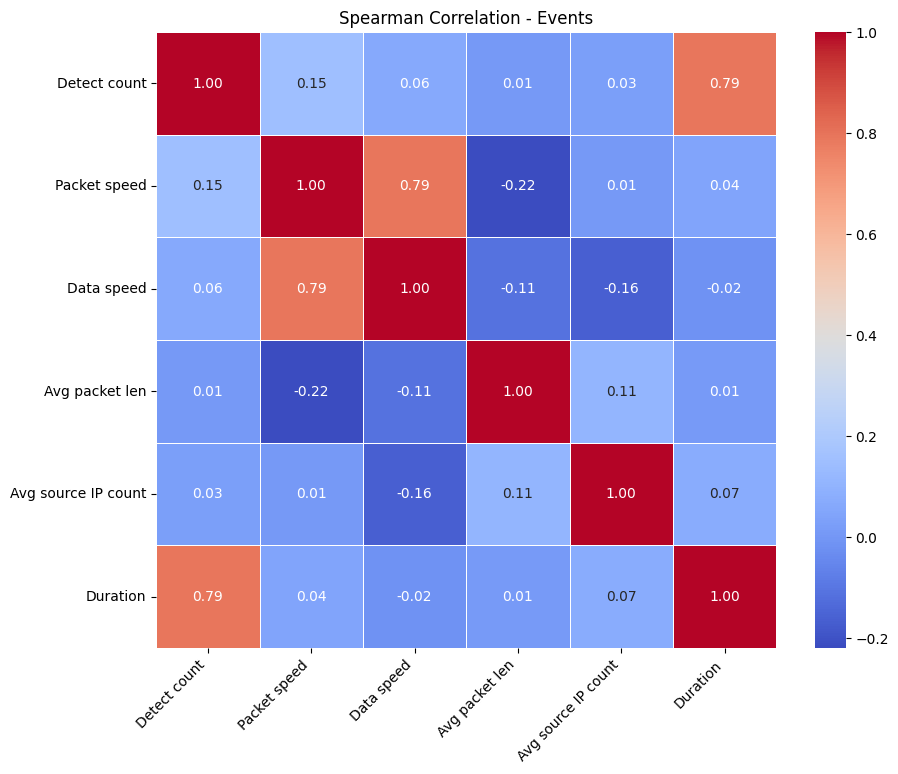

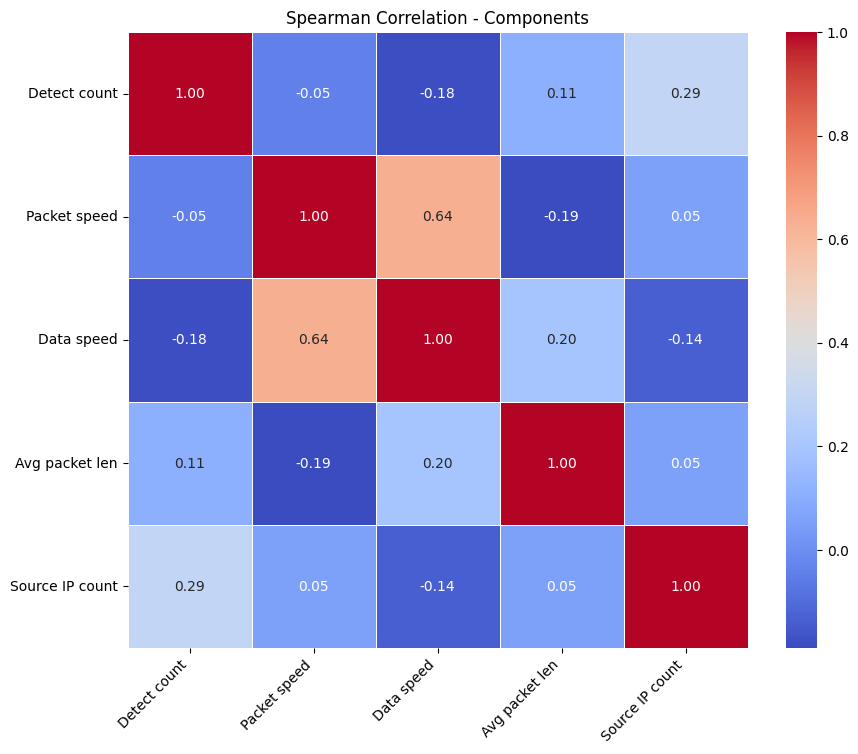

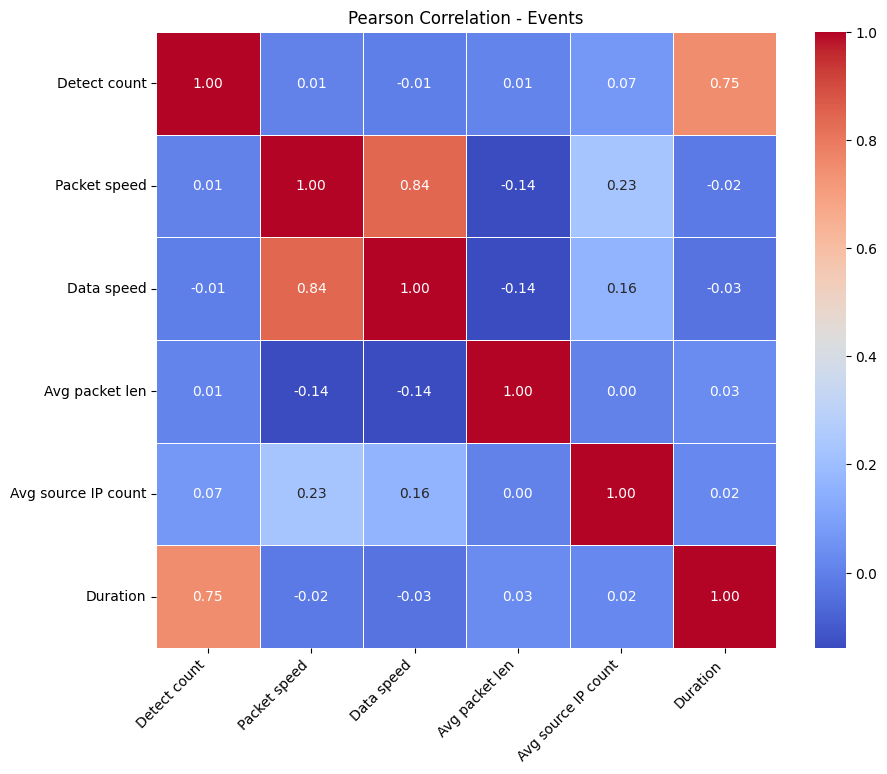

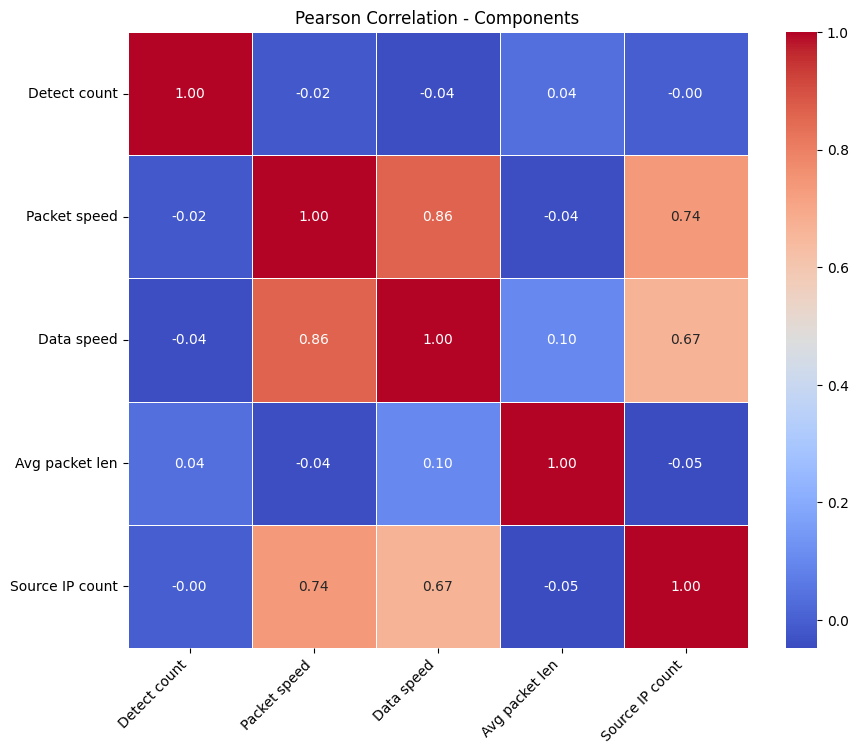

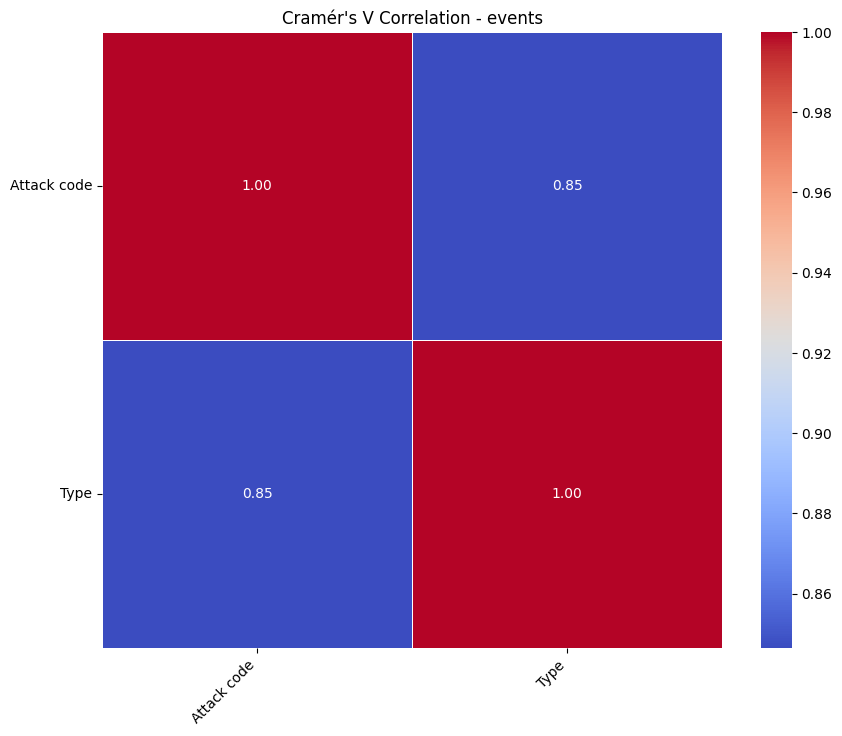

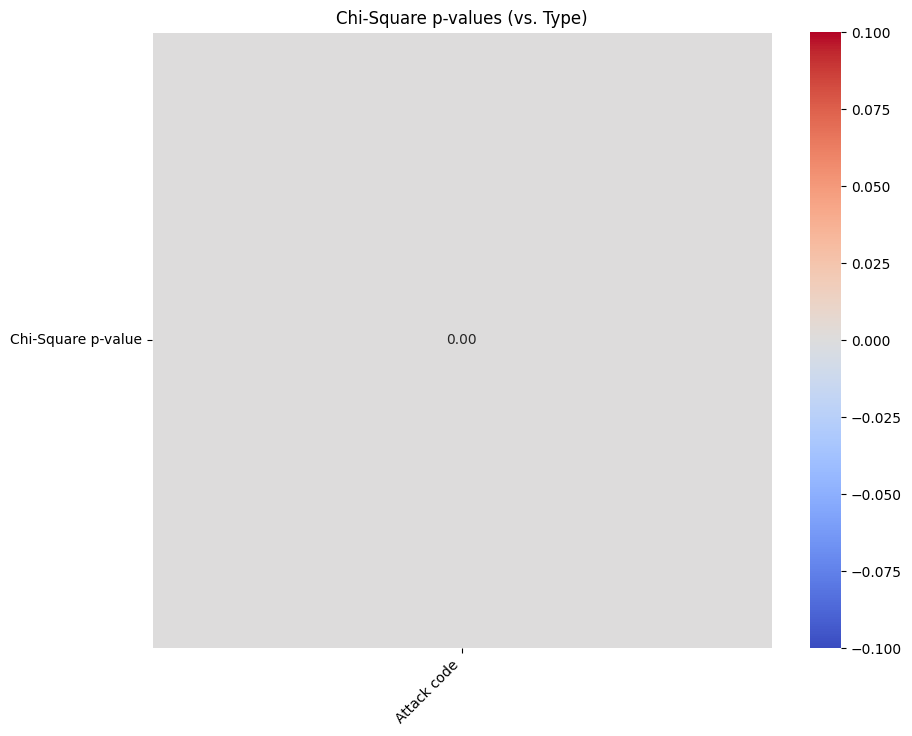

In [59]:
save_plots = False

partition_a.create_heatmap_spearman('events', save_plots)
partition_a.create_heatmap_spearman('components', save_plots)
partition_a.create_heatmap_pearson('events', save=save_plots)
partition_a.create_heatmap_pearson('components', save_plots)
partition_a.create_heatmap_cramers_v('events', save_plots)
partition_a.create_heatmap_chi_square(save_plots)